# LSTM


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
import re
import warnings 
import pandas as pd
warnings.filterwarnings('ignore')
from subprocess import check_output

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
data = pd.read_csv('Reviews.csv')
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [0]:
data = data[['Text','Score']]

In [0]:
data.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [0]:
row_select_1 = data['Score'] < 3
row_select_2 = data['Score'] == 3
data['sentiment'] = pd.Series(['Positive']*len(data.index))
data.loc[row_select_1,'sentiment'] = 'Negative'
data.loc[row_select_2,'sentiment'] = 'Neutral'

In [0]:
data = data[['Text','sentiment']]
data.columns = ['text', 'sentiment']

In [0]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: str(x).lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')

887554
164074


In [0]:
top_words = 5000
max_review_length = 100

In [0]:
tokenizer = Tokenizer(nb_words = top_words, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen = max_review_length)

In [0]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 0)

In [0]:
print(X_train.shape)
print(X_train[1])

(420651, 100)
[1136  648   14    2  181   16  103 2044   11   12  345  437    2  145
   88    4  159 1181 1317    3  176    2   67  552  195    5 2222    5
   78    2  283    4 2810 1180   15    1  351  128    9    8    4 2457
    7 1220  183 1011  979    2   89 1304    1   43   35    4  644 1181
   44   86    1 1690 1140   12  601    8   13    1  969 1827  349   30
  644   14  129 1435  227    2   16  429    5  435   41    1  221    4
  470 3928   13 1724  283   30   41    2   88   87  227   21   18   41
 2269  969]


In [0]:
print(Y_train.shape)
print(Y_train[1])

(420651, 2)
[0 1]


In [0]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 213,402
Trainable params: 213,402
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
history_1 = model.fit(X_train, Y_train, nb_epoch=10, batch_size=500,verbose=1,validation_data=(X_test, Y_test))

Train on 420651 samples, validate on 105163 samples
Epoch 1/10
420651/420651 [==============================] - 942s 2ms/step - loss: 0.0618 - acc: 0.9787 - val_loss: 0.1179 - val_acc: 0.9613
Epoch 2/10
420651/420651 [==============================] - 1171s 3ms/step - loss: 0.0573 - acc: 0.9804 - val_loss: 0.1235 - val_acc: 0.9612
Epoch 3/10
420651/420651 [==============================] - 1316s 3ms/step - loss: 0.0517 - acc: 0.9825 - val_loss: 0.1314 - val_acc: 0.9617
Epoch 4/10
420651/420651 [==============================] - 1260s 3ms/step - loss: 0.0477 - acc: 0.9841 - val_loss: 0.1356 - val_acc: 0.9617
Epoch 5/10
420651/420651 [==============================] - 1208s 3ms/step - loss: 0.0440 - acc: 0.9853 - val_loss: 0.1366 - val_acc: 0.9613
Epoch 6/10
420651/420651 [==============================] - 1314s 3ms/step - loss: 0.0404 - acc: 0.9869 - val_loss: 0.1449 - val_acc: 0.9589
Epoch 7/10
420651/420651 [==============================] - 1439s 3ms/step - loss: 0.0368 - acc: 0.9882

In [0]:
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 96.10%


In [0]:
import matplotlib.pyplot as plt
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,5))
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel('Epochs') 
    plt.ylabel('Binary Crossentropy Loss')
    plt.title('\nBinary Crossentropy Loss VS Epochs')
    plt.legend()
    plt.grid()
    plt.show()

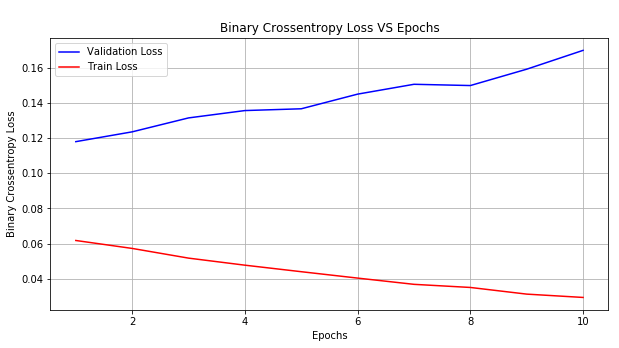

In [0]:
# Test and train accuracy of the model
model_test = scores[1]
model_train = max(history_1.history['acc'])

# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,11))

# Validation loss
vy = history_1.history['val_loss']
# Training loss
ty = history_1.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)